## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [3]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [4]:
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

#import ROOT as r
#import warnings
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

## Section 1: including and visualizing 13 TeV dataset

In [5]:
xvalO = np.load("xvalO.npy")
yvalO = np.load("yvalO.npy")
xerrO = np.load("xerrO.npy")
xlowO = np.load("xlowO.npy")
xval = np.load("xval.npy")
yval = np.load("yval.npy")
xerr = np.load("xerr.npy")

toyList = np.load("toyList.npy")
lumiToyDict = np.load("lumiToyList.npy")
meanGPnom = np.load("initialGPfit.npy")
fixedHyperparams = np.load("fixedHyperparams.npy")

### 4 parameters fit function

In [6]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  #1./(t/sqrts)


## Set up minimization. Look at GP and fit function background only fits to data, and GP and fit function signal+background fits to data+signal

### Calculate bin by bin significance
### calculate bin p value, convert to significance (z). If z is negative, set to 0. If bkg < data, make z negative

In [7]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                #pval = 1.-r.TMath.Gamma(nD+1.,nB)
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                #pval = pval = r.TMath.Gamma(nD,nB)
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                #zval = math.sqrt(2.)*r.TMath.ErfInverse(prob)
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
                #print "crap"
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2



def simpleLogPoisson(x, par):
    if x < 0: 
        #print "crap"
        return np.inf
    elif (x == 0): return -1.*par
    else:
        #lnpoisson = x*np.log(par)-par-r.TMath.LnGamma(x+1.)
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson
    
def makeToys(dataset, nPseudo=1000, lumi = 3.6):
    toys = []
    for n in range(nPseudo):
        pseudo = np.random.poisson(dataset*lumi/3.6)
        toys.append(pseudo)
    return toys

def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

In [8]:
def ncchi(x, nc): #,amp
    return ss.ncx2.pdf(x, 1., nc) #amp*
def cchi(x, amp):
    return amp*ss.chi2.pdf(x, 1.)

In [9]:
#background only plots
def makePrettyPlots_chi2(GPchi2, BKGchi2, title, drawchi2=False, xname=r'$\chi^{2}$', label1 = "Gaussian Process", label2 = "Fit Function"):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=30)

    lowx = min(min(GPchi2), min(BKGchi2))
    highx = max(max(GPchi2), max(BKGchi2))
    bins = np.linspace(lowx, highx, 200)
    
    '''
    hGP = Hist(200, lowx-1, highx+1,markersize=0)
    for chi2 in GPchi2:    
        hGP.Fill(chi2)
    hBKG = Hist(200, lowx-1, highx+1,markersize=0)
    for chi2 in BKGchi2:    
        hBKG.Fill(chi2)
        
    hGP.fillstyle = 'solid'
    hGP.fillcolor = 'green'
    hGP.linecolor = 'black'
    hGP.linewidth = 1
    hGP.Draw("histX0")
    gphist = rplt.bar(hGP, xerr=None, yerr=None, axes=ax1, label=label1)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_title(label1, fontsize=20)
    
    if drawchi2:
        xbins=[]
        ys =[]
        for i in range(hGP.GetNbinsX()):
            xbins.append(hGP.GetBinCenter(i))
            ys.append(hGP.GetBinContent(i))
        #chiPDF=5.*ss.chi2.pdf(xbins , 1)
        
        bf_params, bf_cov = op.curve_fit(ncchi, xbins, ys)
        print "nc, amp ", bf_params
        chiPDF = bf_params[1]*ss.ncx2.pdf(xbins, 1., bf_params[0])

        ax1.plot(xbins, chiPDF, c='r', linewidth=3)
    
    hBKG.fillstyle = 'solid'
    hBKG.fillcolor = 'blue'
    hBKG.linecolor = 'black'
    hBKG.linewidth = 1
    hBKG.Draw("histX0")
    bkghist = rplt.bar(hBKG, xerr=None, yerr=None, axes=ax2, label=label2)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(xname, fontsize=30)
    ax2.set_title(label2, fontsize=20)
    
    if drawchi2:
        xbins=[]
        ys=[]
        for i in range(hBKG.GetNbinsX()):
            xbins.append(hBKG.GetBinCenter(i))
            ys.append(hBKG.GetBinContent(i))
        #chiPDF=5.*ss.chi2.pdf(xbins , 1)
        
        bf_params, bf_cov = op.curve_fit(ncchi, xbins, ys)
        print "nc, amp ", bf_params
        chiPDF = bf_params[1]*ss.ncx2.pdf(xbins, 1., bf_params[0])
        
        ax2.plot(xbins, chiPDF, c='r', linewidth=3)
    
    
    '''


    hGP, _, _ =ax1.hist(GPchi2, bins=bins, color="b", normed=True)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_title(label1, fontsize=20)
    
    if drawchi2:
        bf_params, bf_cov = op.curve_fit(ncchi, bins[:-1], hGP)
        print "amp ", bf_params
        chiPDF = ss.ncx2.pdf(bins, 1., bf_params[0])
        ax1.plot(bins, chiPDF, c='r', linewidth=3)
    
    
    
    hBKG, _, _ =ax2.hist(BKGchi2, bins=bins, color='g', normed=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(xname, fontsize=30)
    ax2.set_title(label2, fontsize=20)
    if drawchi2:
        bf_params, bf_cov = op.curve_fit(ncchi, bins[:-1], hBKG)
        print "amp ", bf_params
        chiPDF = ss.ncx2.pdf(bins, 1., bf_params[0]) #bf_params[1]*
        ax2.plot(bins, chiPDF, c='r', linewidth=3)
    
    plt.show()



In [10]:
def makePrettyPlots_chi2Lumi(lumis, GPchi2, BKGchi2, GPchi2var, BKGchi2var, title):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=30)
    gpPlot = ax1.errorbar(lumis, GPchi2, marker='o', ls='None', yerr = GPchi2var, c='green',  markersize=10, label="Gaussian Process")
    bkgPlot = ax2.errorbar(lumis, BKGchi2, marker='o', ls='None', yerr = BKGchi2var, c='blue',  markersize=10, label="3 param fit function")
    ax1.legend()
    ax1.set_ylabel(r'average $\chi^{2}$', fontsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlim([0, 55])
    
    ax2.legend()
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(r'luminosity $fb^{-1}$', fontsize=20)
    ax2.set_ylabel(r'average $\chi^{2}$', fontsize=20)
    ax2.set_xlim([0, 55])
 
    plt.show()

### Calculate NLL for fit function using poisson statistics - with or without signal. lnprob functions calls logLike function to calculate NLL.

In [11]:
class logLike_3ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    

    
def fit_3ff(lnprob, Print = True):
  #  np.random.seed(1234)
    bestval = np.inf
    bestargs = (0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef=0.5,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, 
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1
        
    if Print:
        print "min LL",bestval
        print "best fit vals", bestargs
    return bestval, bestargs



In [12]:
##Default set max interations 10000
###dijets has errordef 0.5 (defualt 1) - should be 0.5!, tol = 0.001 (so 0.01?)

def model_gp(params, t, xerr=xerr): 
    #global xerr
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

def fit_gp_minuit(lnprob, Print = True):
    #np.random.seed(1234)
    passedFit = False
    bestval = np.inf
    bestargs = (0, 0, 0, 0, 0, 0, 0, 0)
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1e6+1
        init1 = np.random.random() * 400.
        init2 = np.random.random() * 10. 
        init3 = np.random.random() * -100.
        init4 = np.random.random() * 650.
        init5 = np.random.random() * 1.
        init6 = np.random.random() * 1.
        init7 = np.random.random() * -1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef=0.5,
                  Amp = init0, decay = init1, length = init2, power = init3, sub = init4, 
                   p0 = init5, p1 = init6, p2 = init7,
                  error_Amp = 1., error_decay = 0.1, error_length = 0.1, error_power = 0.1, 
                   error_sub = 0.1, error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (100., 1e15), limit_decay = (0, 500), limit_length = (0, 200), 
                   limit_power = (-200, 200), limit_sub = (0, 1000), limit_p0 = (0,10), 
                   limit_p1 = (0, 10), limit_p2 = (-10,0)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
        
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs


class logLike_gp:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, decay, length, power, sub, p0, p1, p2):
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf


In [1]:
print "hi"

hi


In [13]:
print("Fitting gp only")

btime = time.time()
lumiList = [5.0, 10.0, 15.0, 20.0, 25., 30., 35., 40., 45., 50.]


GPtotlist={}
BKGtotlist={}

for lum in lumiList:
    print "lumi", lum
    tList = lumiToyDict[()][lum]

    GPtotlist[lum]=[]
    BKGtotlist[lum]=[]
    failedit=False
    for itoy, toy in enumerate(tList[:1000]):
        if failedit: 
            print "continuing"
            failedit = False
        if not itoy%100:
            print "toy: ", itoy
        lnProb = logLike_3ff(xvalO,toy,xerrO)
        bestvalff, best_fit_ff = fit_3ff(lnProb, False)
        if np.isinf(bestvalff): continue
        bkg = model_3param(xvalO, best_fit_ff, xerrO)
        zvalsff, chi2ff = calcSignificance(toy, bkg)
       
        if not itoy%500:
            print "ff: ", best_fit_ff

    
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        #if itoy == 0:
        lnProb = logLike_gp(xtoy,ytoy,xtoyerr)
        bestvalgp, best_fit_gp = fit_gp_minuit(lnProb, False)
        if np.isinf(bestvalgp): continue
        Amp, decay, length, power, sub, p0, p1, p2 = best_fit_gp
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ytoy))
        try:
            gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        except:
            failedit=True
            print "failed"
            continue
        meanGPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        meanGP = meanGPp+ model_3param(xvalO,(p0,p1,p2),xerrO)
        '''
        else:
            gp.compute(xtoy, np.sqrt(ytoy))
            meanGPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            meanGP = meanGPp+ model_3param(xvalO,(p0,p1,p2),xerrO)
        
        '''

        zvalsgp, chi2gp = calcSignificance(toy, meanGP)


        GPtotlist[lum].append(chi2gp)
        BKGtotlist[lum].append(chi2ff)
            

        if not itoy%500:
            print "bkg NLL", bestvalff
            print "GP NLL", bestvalgp


etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"
print "done with toys, making plot"


Fitting gp only
lumi 5.0
toy:  0
ff:  (0.019436131987526917, 8.05471205440493, -5.278281205685204)
bkg NLL 347.212418066
GP NLL 345.720714025
failed
continuing
failed
continuing
failed
continuing
failed
continuing
failed
continuing
toy:  100
failed
continuing
failed
continuing
failed
continuing
failed
continuing
toy:  200
failed
continuing
failed
continuing
toy:  300
failed
continuing
failed
continuing
failed
continuing
toy:  400
failed
continuing
toy:  500
ff:  (0.022023644951196797, 8.385696215026002, -5.239629782571527)
bkg NLL 333.250844052
GP NLL 328.702652615
failed
continuing
toy:  600
failed
continuing
toy:  700
toy:  800
failed
continuing
failed
continuing
failed
continuing
toy:  900
failed
continuing
lumi 10.0
toy:  0
ff:  (0.04254228562522444, 8.288153792156905, -5.249827899901248)
retry number =  5 : failed fits
failed
continuing
toy:  100
failed
continuing
toy:  200
failed
continuing
toy:  300
failed
continuing
failed
continuing
toy:  400
failed
continuing
failed
continuin

In [16]:
#for lum in lumiList:
#    np.save("GP_chi2_"+str(lum), GPtotlist[lum])
#    np.save("BKG_chi2_"+str(lum), BKGtotlist[lum])
#print len(np.load("GP_chi2_10.0.npy"))
print len(GPtotlist[10])

979


done with toys, making plot
979
LUM 5.0
GP avg 82.7944157172 0.5938243763
BKG avg 78.8291201367 0.425432061165
LUM 10.0
GP avg 81.792279683 0.59370866072
BKG avg 79.1390636418 0.403500587278
LUM 15.0
GP avg 80.0176841982 0.460154374413
BKG avg 79.4171082754 0.413855352268
LUM 20.0
GP avg 79.5718251554 0.466606390808
BKG avg 78.8181587125 0.404801237837
LUM 25.0
GP avg 79.6354645106 0.441535501409
BKG avg 79.1993557169 0.416230802496
LUM 30.0
GP avg 79.1837624681 0.456581103251
BKG avg 79.3041972433 0.401548264112
LUM 35.0
GP avg 80.1247666319 0.442543734705
BKG avg 80.246905142 0.408571206877
LUM 40.0
GP avg 79.5330546705 0.43359169031
BKG avg 79.8816013851 0.395278771941
LUM 45.0
GP avg 79.3585299136 0.454494244841
BKG avg 79.7324003792 0.392144234695
LUM 50.0
GP avg 79.8553751899 0.447421876994
BKG avg 80.5503580302 0.416113048515


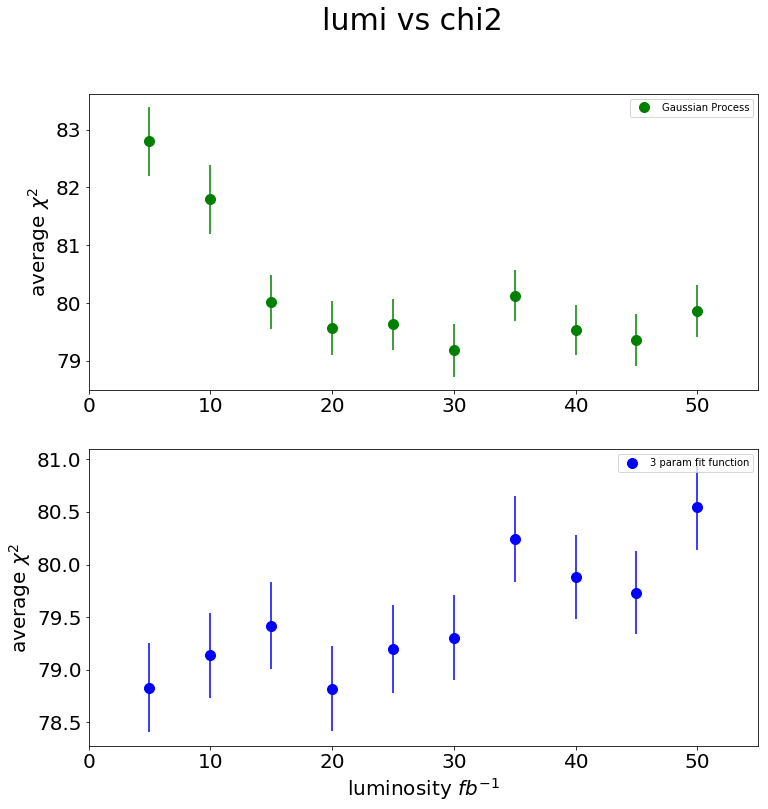

In [22]:
print "done with toys, making plot"
label = "lumi vs chi2"
GPchi2avList=[]
BKGchi2avList=[]
print len(GPtotlist[10])
for lum in lumiList:
    print "LUM", lum
    chi2GPListp = list(np.copy(GPtotlist[lum]))
    chi2BKGListp = list(np.copy(BKGtotlist[lum]))

    for bi, b in enumerate(chi2BKGListp):
        if b > 200: 
            #print "REMOVING", b
            chi2BKGListp.pop(bi)
    for bi, b in enumerate(chi2GPListp):
        if b > 200: 
            #print "REMOVING", b
            chi2GPListp.pop(bi)


    for bi, b in enumerate(chi2BKGListp):
        if b > 200: 
            #print "REMOVING", b
            chi2BKGListp.pop(bi)
    for bi, b in enumerate(chi2GPListp):
        if b > 200: 
            #print "REMOVING", b
            chi2GPListp.pop(bi)        
            
    
#/(len(toy)-1-8)
#/(len(toy)-1-3)
    print "GP avg", np.mean(np.array(chi2GPListp)), np.std(np.array(chi2GPListp)/np.sqrt(len(chi2GPListp)))
    print "BKG avg", np.mean(np.array(chi2BKGListp)), np.std(np.array(chi2BKGListp)/np.sqrt(len(chi2GPListp)))
    GPchi2avList.append([np.mean(np.array(chi2GPListp)), np.std(np.array(chi2GPListp))/np.sqrt(len(chi2GPListp))])
    BKGchi2avList.append([np.mean(np.array(chi2BKGListp)), np.std(np.array(chi2BKGListp))/np.sqrt(len(chi2GPListp))])
makePrettyPlots_chi2Lumi(lumiList, [GPchi2avList[i][0] for i in range(len(lumiList))], [BKGchi2avList[i][0] for i in range(len(lumiList))], [GPchi2avList[i][1] for i in range(len(lumiList))], [BKGchi2avList[i][1] for i in range(len(lumiList))], label)

amp  [ 0.18858934]
amp  [  1.17930536e-05]


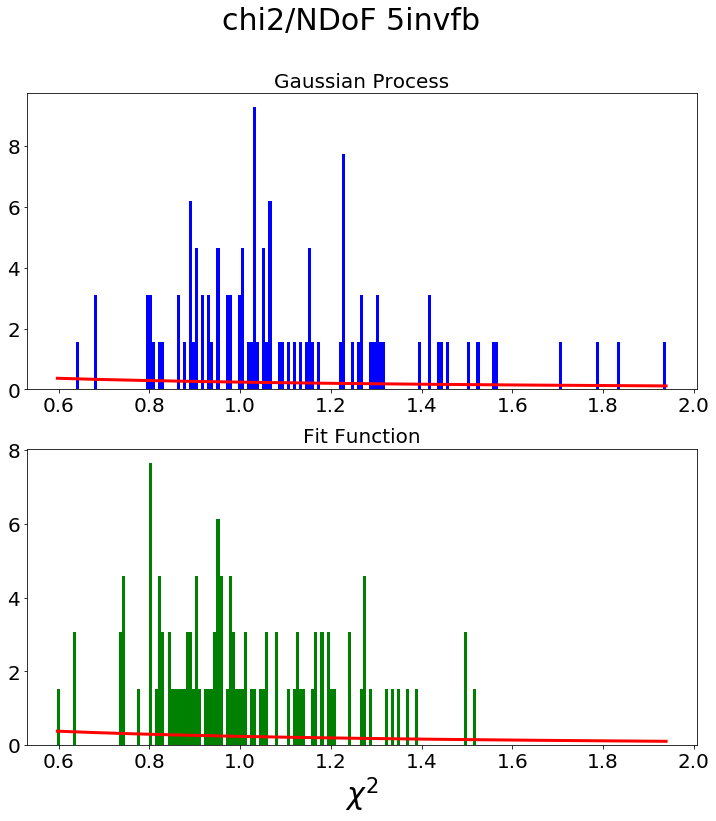

amp  [ 0.12603854]
amp  [  2.70645069e-05]


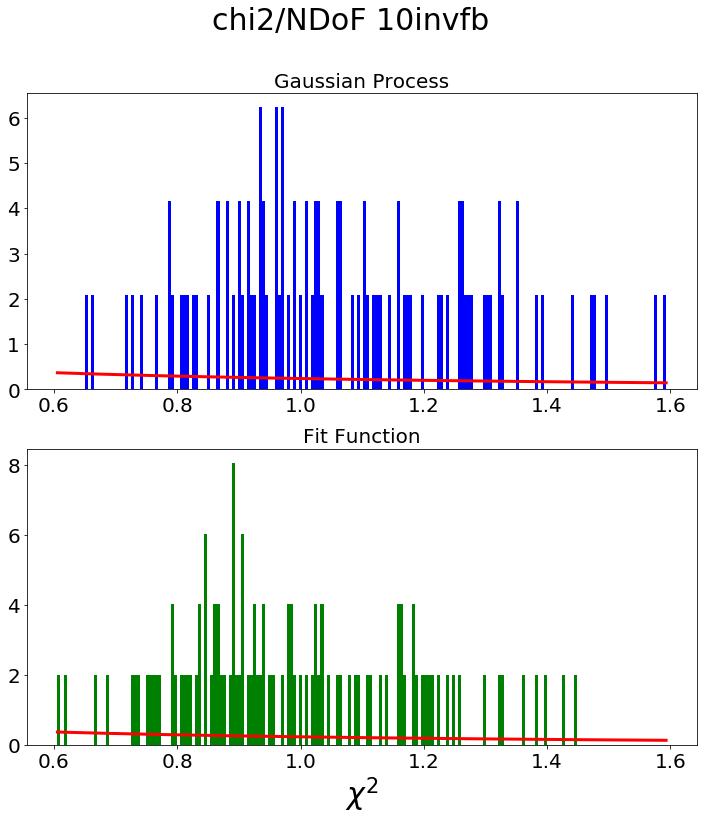

amp  [ 0.07325686]
amp  [  1.64326977e-05]


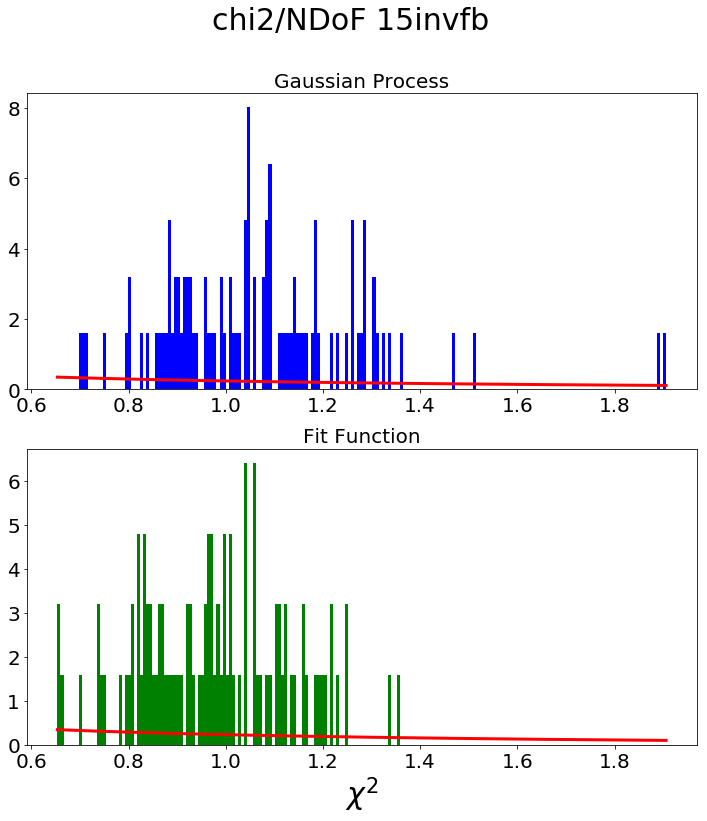

amp  [ 0.07948687]
amp  [  1.93433914e-05]


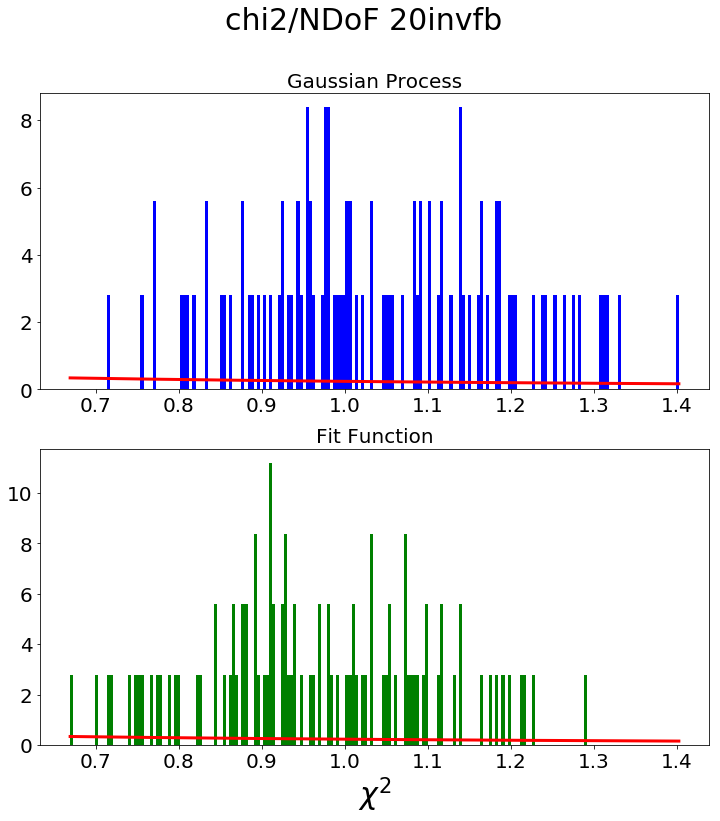

amp  [ 0.16762943]
amp  [  1.82708687e-06]


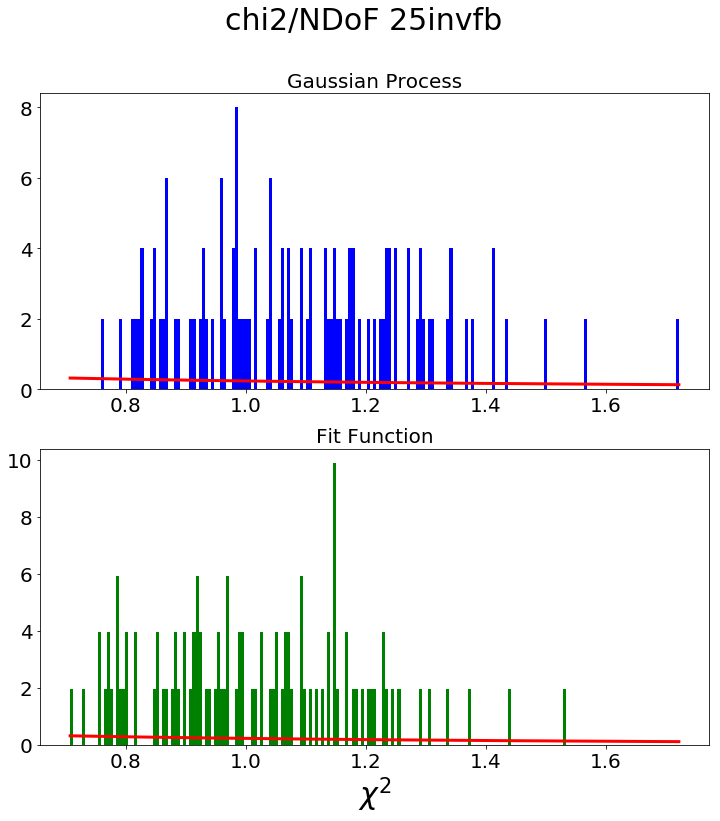

amp  [ 0.27929556]
amp  [ 0.0283111]


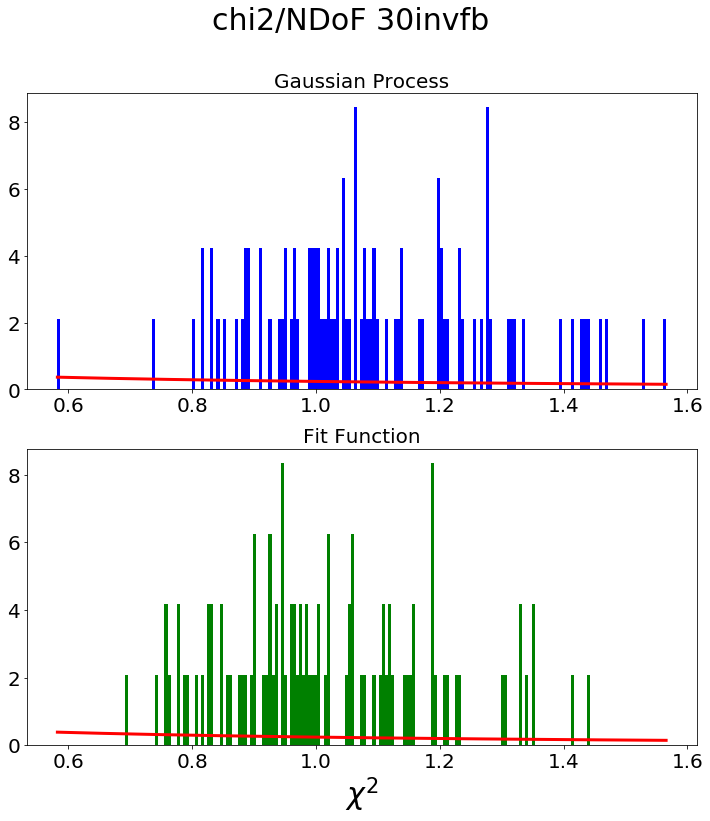

amp  [ 0.15338868]
amp  [  1.22566098e-07]


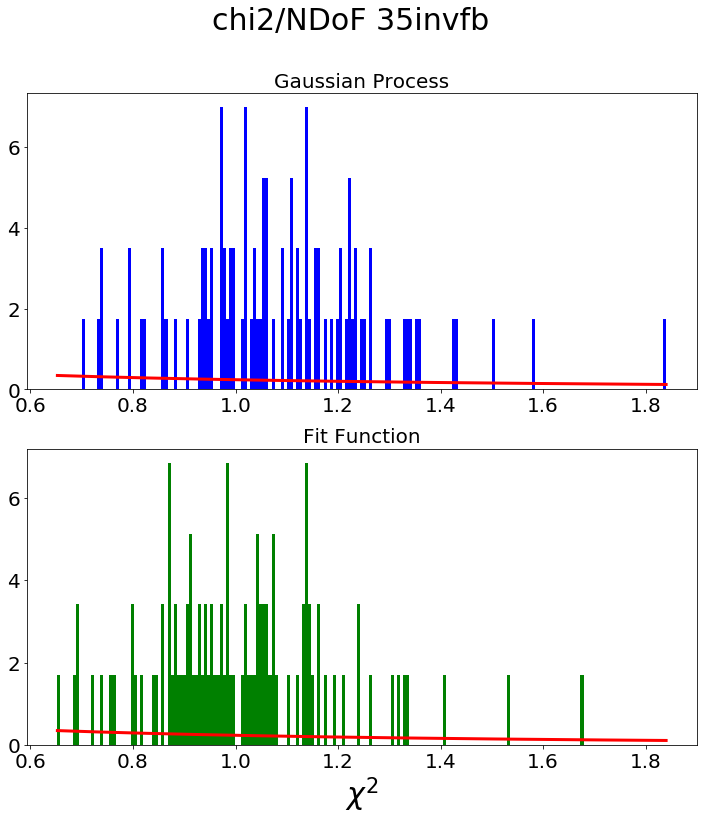

amp  [ 2.11231446]
amp  [ 2.13981651]


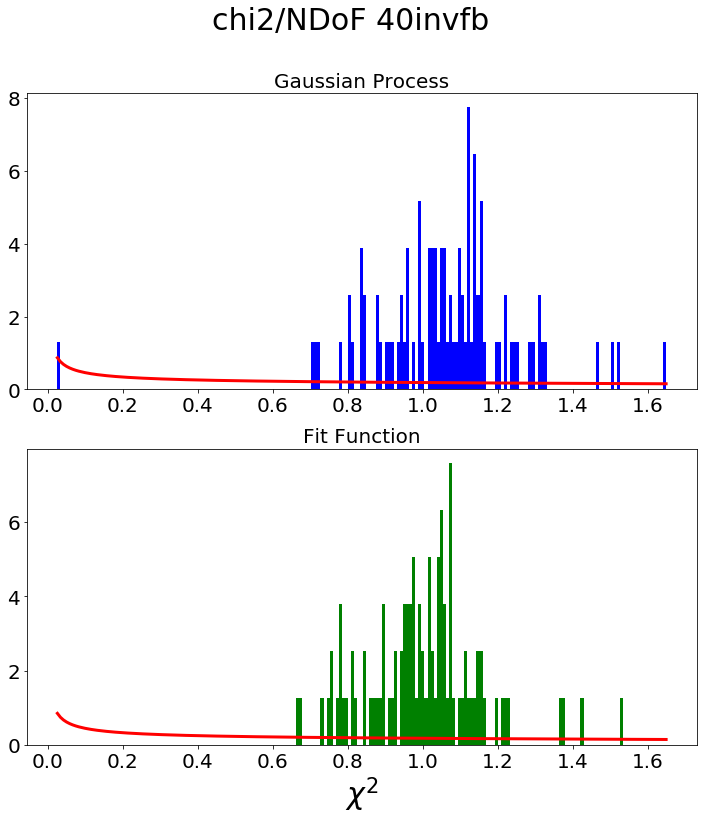

amp  [ 0.09017665]
amp  [  1.57522511e-06]


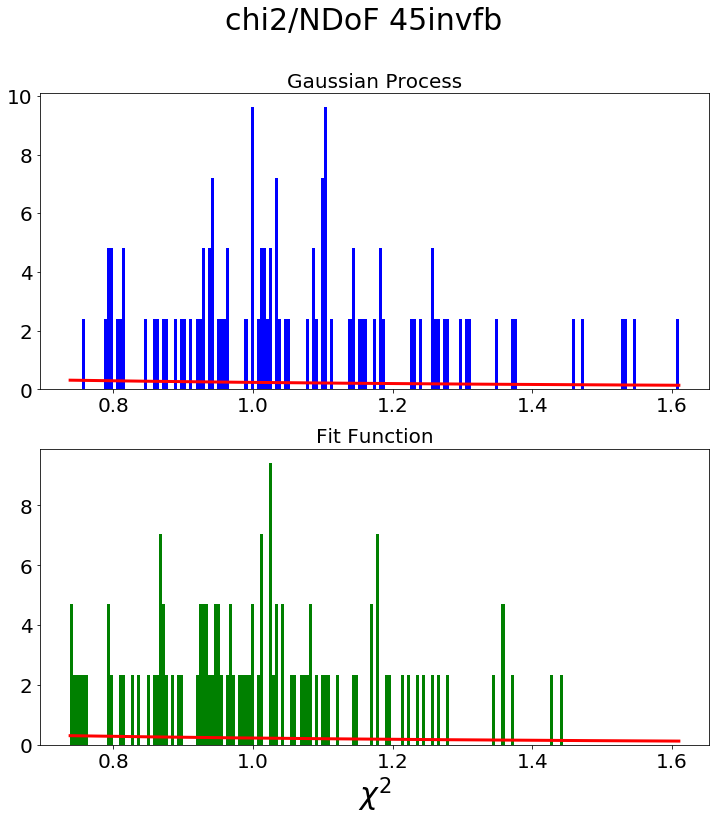

amp  [ 0.24859978]
amp  [ 0.03152033]


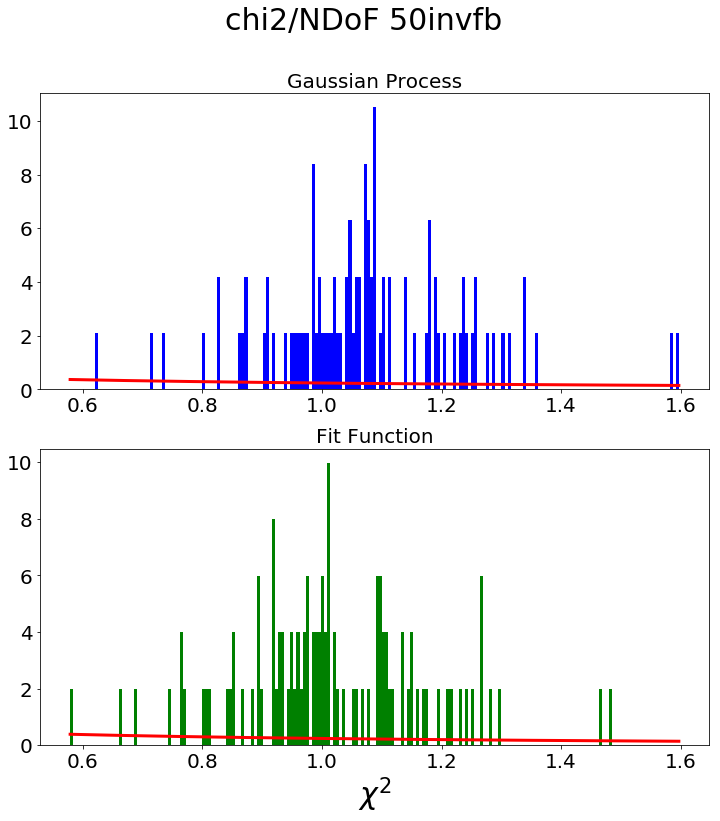

In [97]:
for  b in lumiList:
    label = "chi2/NDoF "+str(int(b))+"invfb"
    makePrettyPlots_chi2(GPtotlist[b], BKGtotlist[b], label, False)